In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install colorama
!pip install keras_tuner

In [ ]:
!pip install tensorflow scikit-learn pydot graphviz

In [ ]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
from colorama import Fore, Back, Style
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageDraw
import itertools
from sklearn.preprocessing import OneHotEncoder
import keras_tuner as kt
from tensorflow.keras.utils import plot_model, model_to_dot
from IPython.display import SVG
from sklearn.metrics import recall_score, precision_score, jaccard_score

In [ ]:
# Read annotations from an xml file
def read_annotations(xml_path):
    '''
    This function reads the ‘xml’ files containing the annotations
    Input: path to the xml file
    Output: a list containing the label and the annotations
    '''
    # Parse the XML file
    tree = ET.parse(xml_path)

    # Get the root element of the XML tree
    root = tree.getroot()

    # Initialize an empty list to store the annotations
    annotations = []

    # Loop through <object> elements in the XML
    for obj in root.findall('object'):

        # Extract the label from the <name> element
        name = obj.find('name').text

        # Extract the bounding box coordinates from the <bndbox> element
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))

    # Return the list of annotations
    return annotations

In [ ]:
def read_data(file_names):
    '''
    This function reads the images from the files.
    Returns a tuple:
    data: The data with images an corresponding annotations
    dims: List of all dimensions encountered throughout the dataset
    '''
    # Initialize two empty lists
    data = []
    dims = []

    # Loop over the file names extracted and read the images and annotations
    for file_name in file_names:

        # Get the paths to the files
        img_path = os.path.join(data_dir, 'JPEGImages',
                                file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Annotations',
                                'Horizontal Bounding Boxes',
                                file_name + '.xml')

        # Read the image
        img = Image.open(img_path)

        # Exclude 4-channel images
        if (np.array(img).shape[2]) != 3:
            continue

        # Extract annotations
        annotations = read_annotations(xml_path)

        # Get the dimensions of all objects and store it for later use
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append(width)
            dims.append(height)

        data.append((img, annotations))


    return data, dims

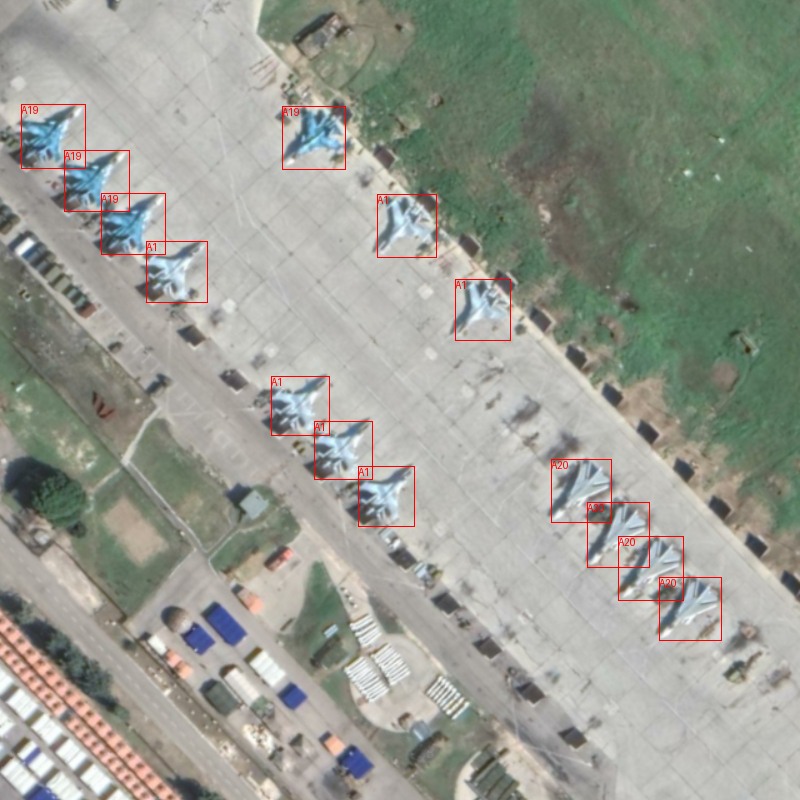

In [ ]:
# Define the path to the data directory
data_dir = '/content/drive/MyDrive/MAR20'
# Read the train and test filenames from the ImageSets/Main folder
with open(os.path.join(data_dir, 'ImageSets/Main/train.txt'), 'r') as f:
    train_filenames = f.read().splitlines()
train_data, train_obj_dims = read_data(train_filenames)

'''
####################### TEST SET #######################
with open(os.path.join(data_dir, 'ImageSets/Main/test.txt'), 'r') as f:
    test_filenames = f.read().splitlines()
test_data, test_obj_dims = read_data(test_filenames)
'''


# Display an exmple
img = train_data[0][0]
draw = ImageDraw.Draw(img)
objects = train_data[0][1]
for obj in objects:
    draw.rectangle(obj[1], outline='red')
    draw.text((obj[1][0], obj[1][1]), obj[0], fill='red')
img

In [ ]:
def pad_img(img):
    '''
    This function transforms an image to the desired size.
    If squared, the image remains the same in ratio;
    if rectnagular, it'll be padded evenly to become a squared one.
    '''
    # Get the dimensions the image
    old_size = img.size

    # Define the desired size to transform the image to
    desired_size = (64,64)

    # Calculate the maximum dimension of the original image
    max_dim = max(old_size)

    # Create a new image with the max_dim as the width and height
    padded = Image.new("RGB", (max_dim, max_dim))

    # Calculate the padding for the image to make it square
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2

    # Paste the original image onto the padded image at the calculated position
    padded.paste(img, (x, y))

    # Resize the padded image to the desired size
    out_img = padded.resize(desired_size)

    # Return the transformed image
    return out_img

In [ ]:
def extract_obj(img, annotations):
    '''
    This function extracts objects from an image based on provided annotations
    '''
    # Define lists to keep objects in an image and their labels
    objects = []
    labels = []

    # Loop through annotations, each of which contain a label and
    # a bounding box denoted by 'b_box'
    for label, b_box in annotations:
        labels.append(label)
        roi = img.crop(b_box)

        # Add roi to the list
        objects.append(roi)


    # Convert labels to numpy array
    labels = np.array(labels)

    # Return objects as individual images as well as their labels
    return objects, labels

In [ ]:
def preprocessing(data):

    # Define two temporary lists to store objects and labels
    X_temp = []
    y_temp = []

    # Iterate over images and annotations to prepare X_train and y_train
    for img, annotations in data:

        # Extract the objects from current image
        objects, labels = extract_obj(img, annotations)

        # Pad objects
        padded = []
        for obj in objects:
            padded_img = pad_img(obj)
            padded.append(padded_img)

        # Add the objects to two temporary lists
        X_temp.append(padded)
        y_temp.append(labels)

    # Flatten the list of labels and convert to numpy array
    orig_labels = list(itertools.chain(*y_temp))
    orig_labels_np = np.array(orig_labels).reshape(-1, 1)

    # Encode the labels
    encoder = OneHotEncoder()
    y = encoder.fit_transform(orig_labels_np).toarray()

    n_channels = 3

    X_list = []

    # Normalize and create a list of image arrays
    for img in X_temp:
        for obj in img:
            X_list.append(np.array(obj)/255.0)

    # Convert the list of images to an array
    X = np.array(X_list)

    return X, y, orig_labels_np

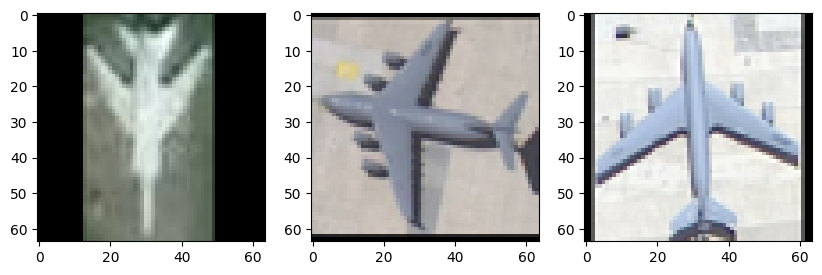

In [ ]:
# Get features and labels
X, y, orig_labels = preprocessing(train_data)
n_labels = y.shape[1]

# Display some of the padded objects
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))
ax0.imshow(X[np.argmin(train_obj_dims)//2], cmap='gray')
ax1.imshow(X[30], cmap='gray')
ax2.imshow(X[np.argmax(train_obj_dims)//2], cmap='gray')

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Shape check
print(Back.RESET + Fore.YELLOW + f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(Back.RESET + Fore.YELLOW + f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")


X_train.shape: (5234, 64, 64, 3)
y_train.shape: (5234, 20)
X_test.shape: (2578, 64, 64, 3)
y_test.shape: (2578, 20)


In [ ]:
# Define a model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(64, 64, 3)))
    model.add(layers.AveragePooling2D((2, 2)))

    # Tune the number of convolutional layers
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(layers.Conv2D(hp.Int(f'filters_{i}', 32, 128, step=32),
                                (3, 3), activation='relu'))
        model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Flatten())

    # Tune the number of units in the dense layer
    model.add(layers.Dense(hp.Int('units', 64, 256, step=32),
                           activation='relu'))

    # Add a dropout layer
    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.add(layers.Dense(n_labels, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


    return model

In [ ]:
# Create a KerasTuner Hyperband tuner
n_labels = y_train.shape[1]
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    directory='my_dir',
    project_name='my_project'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Trial 254 Complete [00h 02m 14s]
val_accuracy: 0.9325058460235596

Best val_accuracy So Far: 0.935608983039856
Total elapsed time: 01h 54m 02s


In [ ]:
# Print the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x783222a37550>
Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.1665 - loss: 2.7122 - val_accuracy: 0.4744 - val_loss: 1.6833
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4536 - loss: 1.7575 - val_accuracy: 0.6191 - val_loss: 1.2206
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5620 - loss: 1.3456 - val_accuracy: 0.7106 - val_loss: 0.9123
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6652 - loss: 1.0625 - val_accuracy: 0.7386 - val_loss: 0.8529
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6975 - loss: 0.8987 - val_accuracy: 0.8119 - val_loss: 0.6261
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7418 - loss: 0.7748 - val_accuracy: 0.8425 - val_loss: 0.5329
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7909 - loss: 0.6271 - val_accuracy: 0.

In [ ]:
## Test the model
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Visualize the model
plot_model(model, to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Summarize the model
model.summary()

# Print test loss and accuracy
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Assuming y_test and y_pred are the true labels and predicted labels respectively
##y_pred = model.predict(X_test)
#y_pred_classes = y_pred.argmax(axis=1)  # Assuming you have categorical output

# Calculate additional metrics
#recall = recall_score(y_test, y_pred_classes)
#precision = precision_score(y_test, y_pred_classes)
#iou = jaccard_score(y_test, y_pred_classes)

#print(f"Recall: {recall}")
#print(f"Precision: {precision}")
#print(f"IOU: {iou}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9200 - loss: 0.5854


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 31, 31, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 14, 14, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 6, 6, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,111,550 (15.68 MB)

 Trainable params: 1,370,516 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,741,034 (10.46 MB)

Test Loss: 0.5467493534088135
Test Accuracy: 0.9235841631889343


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


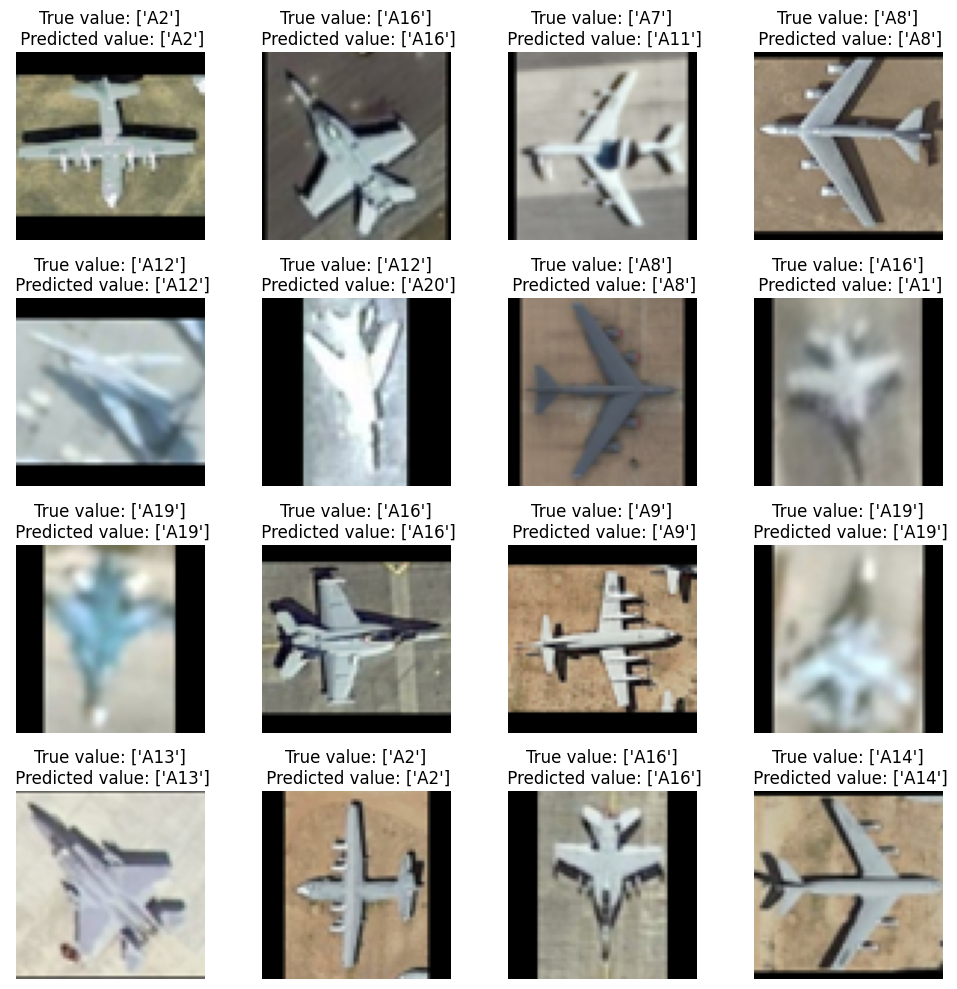

In [ ]:
predictions = model.predict(X_test)

# Create a new instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on the original categorical labels
encoder.fit(orig_labels)

# Perform the inverse transformation using the OneHotEncoder
y_orig_true = encoder.inverse_transform(y_test)
y_orig_pred = encoder.inverse_transform(predictions)

# Display 16 predictions

# Set up the subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.ravel()

# Generate some random indices
random_numbers = []
for _ in range(16):
    random_number = random.randint(0, X_test.shape[0])
    random_numbers.append(random_number)

for i, rand in enumerate(random_numbers):
    axs[i].imshow(X_test[rand], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"True value: {y_orig_true[rand]}\n Predicted value: {y_orig_pred[rand]}")

plt.tight_layout()
plt.show()

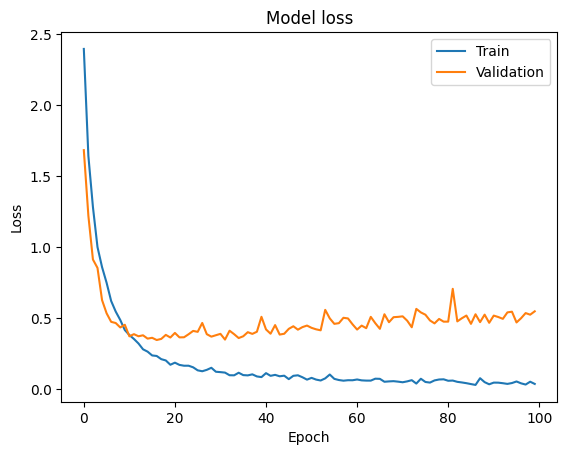

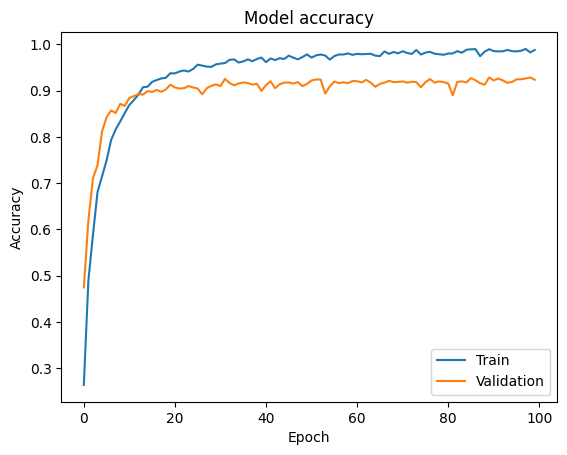

In [ ]:
# Plot the performance of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9909 - loss: 0.0242 - val_accuracy: 0.9943 - val_loss: 0.0157
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9897 - loss: 0.0291 - val_accuracy: 0.9952 - val_loss: 0.0163
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9947 - loss: 0.0202 - val_accuracy: 0.9933 - val_loss: 0.0186
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9925 - loss: 0.0199 - val_accuracy: 0.9933 - val_loss: 0.0220
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9910 - loss: 0.0315 - val_accuracy: 0.9962 - val_loss: 0.0175
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9945 - loss: 0.0142 - val_accuracy: 0.9943 - val_loss: 0.0172
Epoch 7/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9921 - loss: 0.0204 - val_accuracy: 0.9943 - val_loss: 0.0225
Epoch 8/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9948 - loss: 0.0139 - val_accuracy: 0.

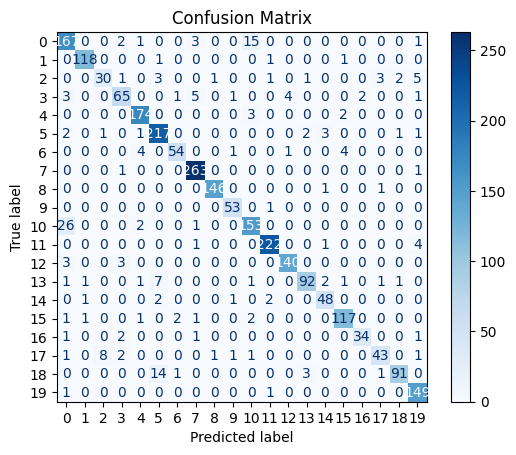

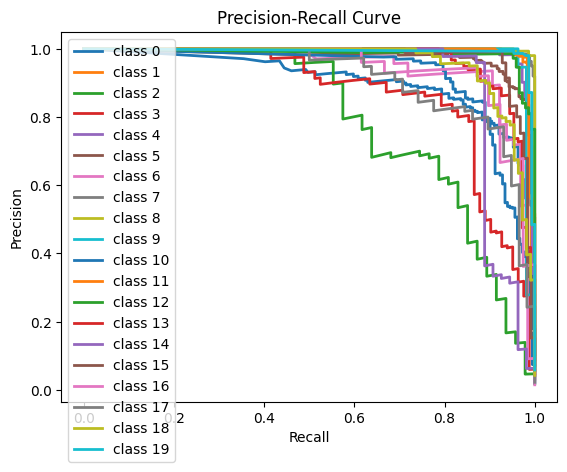

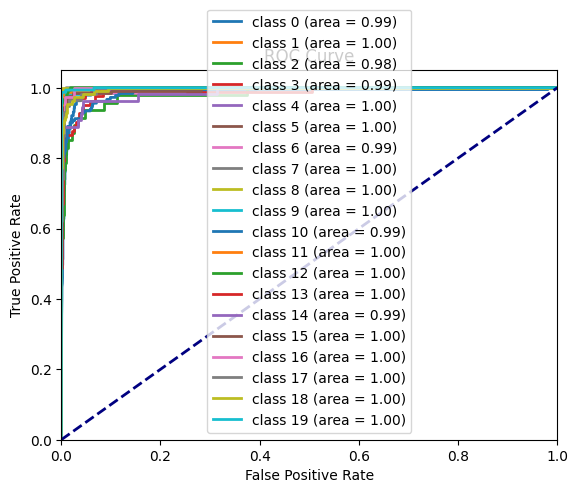

False Positive Rate: 0.0
False Positive Rate: 0.00041203131437989287
False Positive Rate: 0.00041203131437989287
False Positive Rate: 0.00041203131437989287
False Positive Rate: 0.0008240626287597857
False Positive Rate: 0.0008240626287597857
False Positive Rate: 0.0012360939431396785
False Positive Rate: 0.0012360939431396785
False Positive Rate: 0.009064688916357644
False Positive Rate: 0.009064688916357644
False Positive Rate: 0.06592501030078286
False Positive Rate: 0.06592501030078286
False Positive Rate: 0.9456118665018541
False Positive Rate: 0.9472599917593737
False Positive Rate: 0.950144210960033
False Positive Rate: 1.0
Test Loss: 0.6950003504753113
Test Accuracy: 0.9216446876525879
Recall: 0.8947483897690407
Precision: 0.9149251244874941
IOU: 0.8308738756752312
false positive rate: [0.00000000e+00 4.12031314e-04 4.12031314e-04 4.12031314e-04
 8.24062629e-04 8.24062629e-04 1.23609394e-03 1.23609394e-03
 9.06468892e-03 9.06468892e-03 6.59250103e-02 6.59250103e-02
 9.45611867e

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming model, X_train, y_train, X_test, y_test are already defined and the model is trained

# Train the model and save the history
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=32)

# Predict the classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot precision-recall curve
y_test_bin = label_binarize(y_test_classes, classes=np.arange(len(np.unique(y_test_classes))))
n_classes = y_test_bin.shape[1]

plt.figure()
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {i}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'class {i} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()
for fp_rate in fpr:
    print(f"False Positive Rate: {fp_rate}")

# Print final test metrics
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
iou = jaccard_score(y_test_classes, y_pred_classes, average='macro')

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"IOU: {iou}")
print(f"false positive rate: {fpr}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


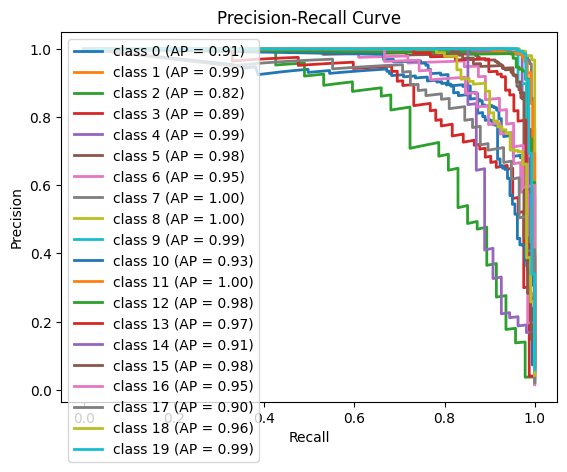

Test Loss: 0.6468594670295715
Test Accuracy: 0.9294026494026184
Recall: 0.8985862400430292
Precision: 0.9236803820364641
IOU: 0.8409914806016948
Mean Average Precision (mAP): 0.95


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Assuming model, X_test, y_test are already defined and the model is trained

# Predict the classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Binarize the test labels
y_test_bin = label_binarize(y_test_classes, classes=np.arange(len(np.unique(y_test_classes))))
n_classes = y_test_bin.shape[1]

# Calculate precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred[:, i])

# Compute mean average precision
mean_average_precision = np.mean(list(average_precision.values()))

# Plot precision-recall curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'class {i} (AP = {average_precision[i]:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

# Print final test metrics
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
recall_metric = recall_score(y_test_classes, y_pred_classes, average='macro')
precision_metric = precision_score(y_test_classes, y_pred_classes, average='macro')
iou = jaccard_score(y_test_classes, y_pred_classes, average='macro')

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Recall: {recall_metric}")
print(f"Precision: {precision_metric}")
print(f"IOU: {iou}")
print(f"Mean Average Precision (mAP): {mean_average_precision:.2f}")


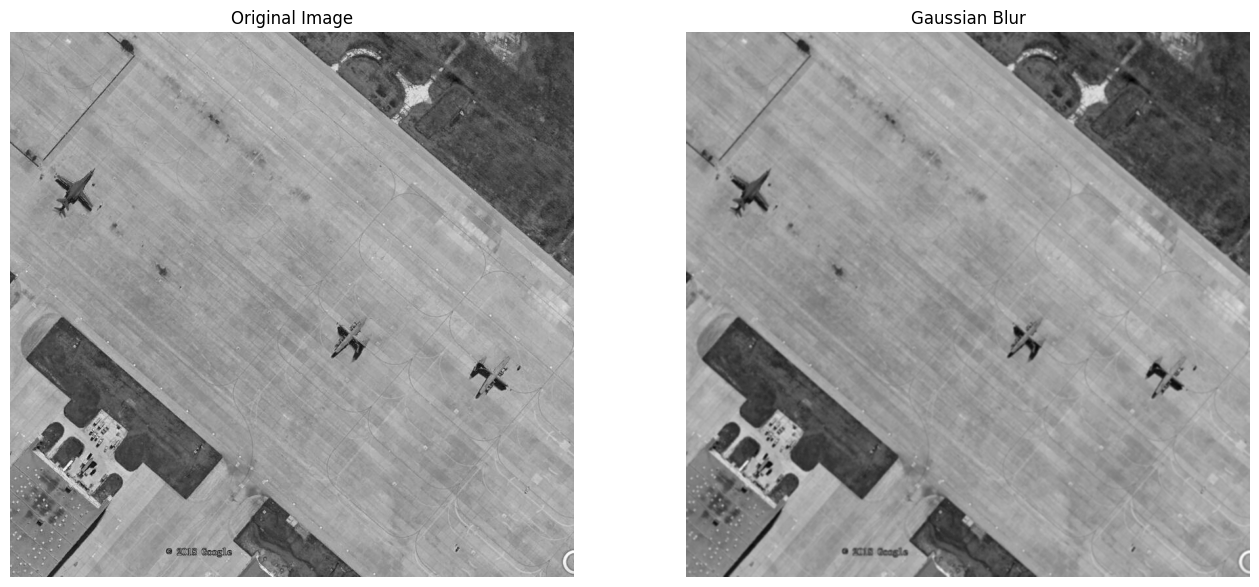

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_images(images, titles):
    plt.figure(figsize=(16, 8))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Load an image
image = cv2.imread('/content/drive/MyDrive/MAR20/JPEGImages/1.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur
gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Median Filtering
#median_blur = cv2.medianBlur(image, 5)

# Apply Bilateral Filtering
#bilateral_filter = cv2.bilateralFilter(image, 9, 75, 75)

# Show the original and processed images
titles = ['Original Image', 'Gaussian Blur']
images = [image, gaussian_blur]

show_images(images, titles)


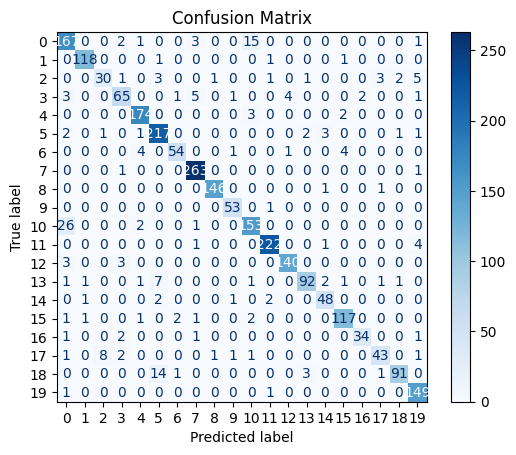

Overall True Positives (TP): 2376
Overall False Positives (FP): 202
Overall True Negatives (TN): 48780
Overall False Negatives (FN): 202
Overall False Positive Rate (FPR): 0.0041239639051079986


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code) ...

# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display the confusion matrix directly
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Calculate overall TP, FP, TN, FN for multi-class classification
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sum across all classes to get overall values
overall_TP = TP.sum()
overall_FP = FP.sum()
overall_TN = TN.sum()
overall_FN = FN.sum()

# Calculate overall FPR
overall_FPR = overall_FP / (overall_FP + overall_TN) if (overall_FP + overall_TN) > 0 else 0

print(f"Overall True Positives (TP): {overall_TP}")
print(f"Overall False Positives (FP): {overall_FP}")
print(f"Overall True Negatives (TN): {overall_TN}")
print(f"Overall False Negatives (FN): {overall_FN}")
print(f"Overall False Positive Rate (FPR): {overall_FPR}")

# ... (rest of your code) ...

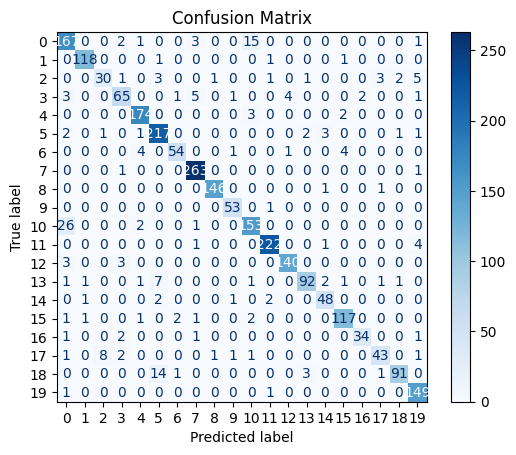

Overall True Positives (TP): 2376
Overall False Positives (FP): 202
Overall True Negatives (TN): 48780
Overall False Negatives (FN): 202
Overall False Positive Rate (FPR): 0.0041239639051079986
Overall False Positive Rate (FPR) in percentage: 0.41%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code) ...

# Calculate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display the confusion matrix directly
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Calculate overall TP, FP, TN, FN for multi-class classification
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sum across all classes to get overall values
overall_TP = TP.sum()
overall_FP = FP.sum()
overall_TN = TN.sum()
overall_FN = FN.sum()

# Calculate overall FPR in percentage
overall_FPR = overall_FP / (overall_FP + overall_TN) if (overall_FP + overall_TN) > 0 else 0
overall_FPR_percentage = overall_FPR * 100

print(f"Overall True Positives (TP): {overall_TP}")
print(f"Overall False Positives (FP): {overall_FP}")
print(f"Overall True Negatives (TN): {overall_TN}")
print(f"Overall False Negatives (FN): {overall_FN}")
print(f"Overall False Positive Rate (FPR): {overall_FPR}")
print(f"Overall False Positive Rate (FPR) in percentage: {overall_FPR_percentage:.2f}%")

# ... (rest of your code) ...

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code) ...

# Find the number of layers in the model
num_layers = len(model.layers)
print(f"Number of layers in the model: {num_layers}")

Number of layers in the model: 10


In [ ]:
all_filters = []

for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D):  # Check if the layer is a Conv2D layer
        filters, biases = layer.get_weights()
        all_filters.append(filters)  # Append the filters to the list
print(filters)
# Now, all_filters contains a list of filter arrays from all Conv2D layers

[[[[-1.58394023e-03 -3.03823091e-02 -4.82378490e-02 ... -4.60849315e-01
    -3.29049490e-02  5.76434610e-03]
   [-1.44584075e-01  5.03701298e-03 -4.50816415e-02 ...  2.27857218e-03
    -4.43085432e-02 -2.58053448e-02]
   [ 2.26142198e-01 -1.49774164e-01 -2.04973184e-02 ...  4.50023748e-02
    -4.55072820e-02 -3.07466518e-02]
   ...
   [-4.91909392e-04  4.75641042e-02 -2.29034889e-02 ... -4.08082921e-03
     7.74351321e-03 -8.19714833e-03]
   [-1.34486303e-01 -8.65671560e-02 -3.25951762e-02 ...  1.03092119e-01
    -3.09380293e-02 -1.94893368e-02]
   [-5.74310571e-02 -4.17803079e-02  2.66994387e-02 ... -2.33051613e-01
     2.64521372e-02 -2.86609679e-02]]

  [[-1.42948836e-01 -2.03981251e-01 -4.08196747e-02 ...  3.65410000e-04
    -5.17576300e-02  3.35563673e-03]
   [-9.37698875e-03 -9.27331392e-03 -3.04561909e-02 ...  2.17659220e-01
    -3.53752151e-02 -1.05219632e-02]
   [ 4.15148407e-01 -8.04525986e-03 -7.46713877e-02 ... -2.51295596e-01
    -1.84853002e-02  3.63971516e-02]
   ...
   

In [ ]:
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D):
        strides = layer.strides
        print(f"Strides for layer {layer.name}: {strides}")

Strides for layer conv2d_3: (1, 1)
Strides for layer conv2d_4: (1, 1)
Strides for layer conv2d_5: (1, 1)


In [ ]:
input_shape = model.input_shape
print(f"Input shape of the model: {input_shape}")

Input shape of the model: (None, 64, 64, 3)


In [ ]:
input_shape = model.input_shape
print(f"Input shape of the model: {input_shape}")

# Extract the image dimensions (height, width, channels)
height = input_shape[1]
width = input_shape[2]
channels = input_shape[3]  # If the model expects color images

print(f"Original image size: {width} x {height} pixels")
print(f"Number of channels: {channels}")

Input shape of the model: (None, 64, 64, 3)
Original image size: 64 x 64 pixels
Number of channels: 3


In [ ]:
model_name = model.name
print(f"Model name: {model_name}")

Model name: sequential_1
